In [214]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import scipy.signal as fp
import os
import re

In [215]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [216]:
def bkg_corrector(bkg_list,data_list):
    bkg_corr_data_list=[]
    for i in range(0,len(bkg_list)):
        bkg_corr_data=data_list[i]-bkg_list[i]
        bkg_corr_data_list.append(bkg_corr_data)
    bkg_corr_data_list=np.array(bkg_corr_data_list).clip(min=0)
    return bkg_corr_data_list

In [217]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))
#defining the gaussian

In [218]:
def peak_fitter(function, channel, data_list,fit_range,init_guess):
    mu, cov=sci.curve_fit(function,channel[fit_range[0]:fit_range[1]],data_list[fit_range[0]:fit_range[1]],p0=init_guess)
    gauss=gaussian(channel[fit_range[0]:fit_range[1]],*mu)
    channel_no_ranged=channel[fit_range[0]:fit_range[1]]
    return channel_no_ranged, gauss, mu, cov

In [219]:
def graphfitter(range_list,num_peak,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    centroid_list=[]
    # for peak_num in num_peak:
    for peaks in range(0,num_peak):
        ranged_channel,fit_gauss,mu,cov = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
        ranged_channel_list.append(ranged_channel)
        fit_gauss_list.append(fit_gauss)
        centroid_error=np.sqrt(np.diag(cov))
        print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
        print(f"The centroid for peak {peaks}:",mu[1])
        print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
        centroid_list.append(mu[1])
    return ranged_channel_list, fit_gauss_list,centroid_list

In [220]:
bkg=extract_mca_data("team_battery/bkg_10_1789.mca")

In [221]:
raw_E_spectrum_fe=extract_mca_data("team_battery/fe_10_1789_spectrum.mca")
raw_E_spectrum_am=extract_mca_data("team_battery/am_10_1790_spectrum.mca")
raw_E_spectrum_ba=extract_mca_data("team_battery/ba_10_1790_spectrum.mca")

In [222]:
channel_no=np.arange(1,len(raw_E_spectrum_fe)+1)

In [223]:
E_spectrum_fe=bkg_corrector(bkg,raw_E_spectrum_fe)
E_spectrum_am=bkg_corrector(bkg,raw_E_spectrum_am)
E_spectrum_ba=bkg_corrector(bkg,raw_E_spectrum_ba)

The fitting range for peak 0: 27 35
The centroid for peak 0: 31.618991146926287
The error on the centroid fit for peak 0: 0.18621426500320087
The fitting range for peak 1: 53 72
The centroid for peak 1: 61.39341365150894
The error on the centroid fit for peak 1: 0.07780334401744748


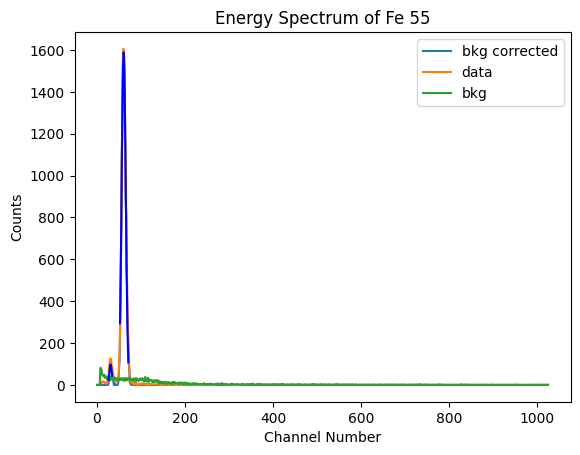

In [224]:
fe_fitting_range=[[26,35],[52,72]]
fe_p0=[[100,33,10],[1600,60,10]]
fe_range_channnel,fit_fe_gauss,fe_centroid_list=graphfitter(fe_fitting_range,2,gaussian,channel_no,E_spectrum_fe,fe_p0)
plt.plot(channel_no,E_spectrum_fe,label='bkg corrected')
plt.plot(channel_no,raw_E_spectrum_fe,label='data')
plt.plot(channel_no,bkg,label='bkg')
# plt.plot(peak_positions,peak_pnts,'k.')
plt.xlabel("Channel Number")
plt.ylabel("Counts")
plt.title("Energy Spectrum of Fe 55")
plt.legend()
# plt.xlim(500,650)
for fitpeak in range(0,len(fe_fitting_range)):
    plt.plot(fe_range_channnel[fitpeak],fit_fe_gauss[fitpeak],color='blue')

The fitting range for peak 0: 161 195
The centroid for peak 0: 174.94392333064422
The error on the centroid fit for peak 0: 0.22550641560146018
The fitting range for peak 1: 241 290
The centroid for peak 1: 259.28826051716004
The error on the centroid fit for peak 1: 0.45220172628061134
The fitting range for peak 2: 561 640
The centroid for peak 2: 585.7361751885699
The error on the centroid fit for peak 2: 0.5233782983739608


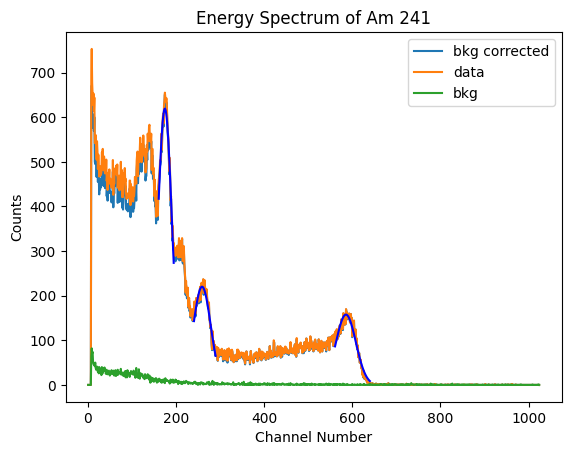

In [225]:


am_fitting_range=[[160,195],[240,290],[560,640]]
am_p0=[[700,170,10],[300,260,200],[170,520,16]]
am_range_channnel,fit_am_gauss,am_centroid_list=graphfitter(am_fitting_range,len(am_fitting_range),gaussian,channel_no,E_spectrum_am,am_p0)

plt.plot(channel_no,E_spectrum_am,label='bkg corrected')
plt.plot(channel_no,raw_E_spectrum_am,label='data')
plt.plot(channel_no,bkg,label='bkg')
plt.xlabel("Channel Number")
plt.ylabel("Counts")
plt.title("Energy Spectrum of Am 241")
# plt.xlim(0,200)
plt.legend()
for fitpeak in range(0,len(am_fitting_range)):
    plt.plot(am_range_channnel[fitpeak],fit_am_gauss[fitpeak],color='blue')

The fitting range for peak 0: 261 340
The centroid for peak 0: 301.4192177263182
The error on the centroid fit for peak 0: 0.3652236499077082


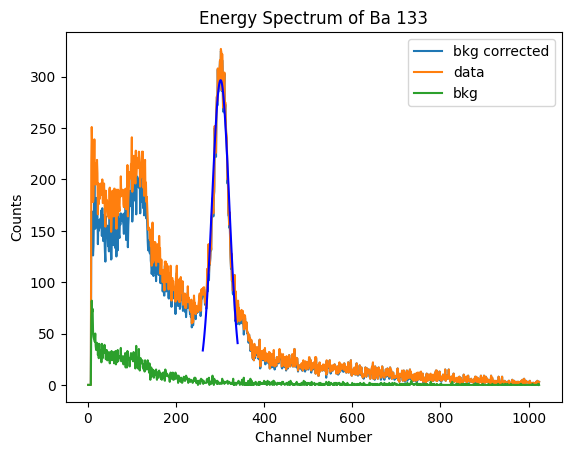

In [226]:
ba_fitting_range=[[260,340]]
ba_p0=[[300,290,30]]
ba_range_channnel,fit_ba_gauss,ba_centroid_list=graphfitter(ba_fitting_range,1,gaussian,channel_no,E_spectrum_ba,ba_p0)
plt.plot(channel_no,E_spectrum_ba,label='bkg corrected')
plt.plot(channel_no,raw_E_spectrum_ba,label='data')
plt.plot(channel_no,bkg,label='bkg')
plt.plot(ba_range_channnel[0],fit_ba_gauss[0],color='blue')
plt.xlabel("Channel Number")
plt.ylabel("Counts")
plt.title("Energy Spectrum of Ba 133")
# plt.xlim(0,350)
plt.legend()
# plt.show()

[np.float64(31.618991146926287), np.float64(61.39341365150894), np.float64(585.7361751885699)]


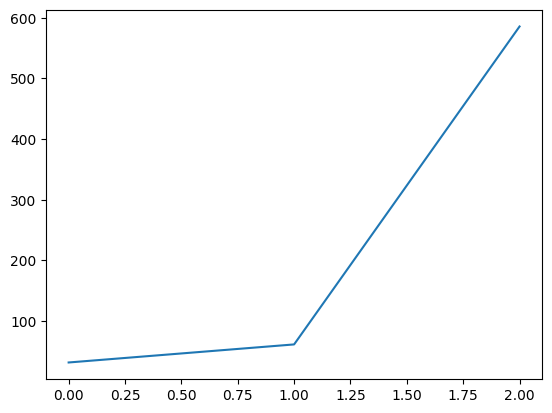

In [227]:
all_centroid_list = [fe_centroid_list]
all_centroid_list = [x for sublist in all_centroid_list for x in sublist]
all_centroid_list.append(am_centroid_list[-1])
print(all_centroid_list)
plt.plot(all_centroid_list)